# Introduction

Title drafting:

- Performing the Analytic Hierarchy Process with survey data from \\emph{SoSci Survey} and R-package \\emph{ahpsurvey}
- Auswertung der Umfragedaten aus \\emph{SoSci Survey} zum Thema \\emph{Essbare Städte} mit Hilfe des Analytic Hierarchy Process (AHP) und dem R-Paket \\emph{ahpsurvey}
- Analysis of survey data from \\emph{SoSci Survey} in the \\emph{Edible Cities} project using the Analytic Hierarchy Process (AHP) and the R-package \\emph{ahpsurvey}

Why we use a [Jupyter](https://en.wikipedia.org/wiki/Project_Jupyter) notebook to to publish the R program examples:

Jupyter is a new **open source** alternative to the proprietary numerical software [Mathematica](https://en.wikipedia.org/wiki/Wolfram_Mathematica) from **Wolfram Research** that is well on the way to become a **standard for exchanging research results** (<cite data-cite="Scientific_Paper_obsolete_2018">Somers, 2018</cite>; <cite data-cite="Future_of_Research_Paper_2018">Romer, 2018</cite>).

Originally Jupyter was intended as an IDE for the programming languages **Julia** and **Python**. Besides that it is also possible to install other interpreter kernels, such as the **[IRkernel](https://irkernel.github.io/installation/)** for R. This can be interesting if the IDE **RStudio Desktop** is not available on the target platform used. For example, it is very difficult to install RStudio on the ARM-based embedded computer **Raspberry Pi** due to many technical dependencies. In contrast, using the R kernel in JupyterLab on the Raspberry Pi works very well and performant.

# Global loading of the used R packages and definition of globally used functions

## Install missing packages if not present yet

**Attention:** For some R packages several dependencies have to be installed first with `apt install <package name>`.

Dependencies for package `ahpsurvey`:  
- R package `randomNames` (it depends on R ≥ 4.0, refer to [https://cran.r-project.org/web/packages/randomNames/index.html](https://cran.r-project.org/web/packages/randomNames/index.html))

Drawback for **Raspbian buster**: the dependency `randomNames` is not available for R v3.5.2 as it depends on R (≥ 4.0). Upgrading R in Raspbian following the instruction on [https://cran.rstudio.com/bin/linux/debian/#debian-buster-stable](https://cran.rstudio.com/bin/linux/debian/#debian-buster-stable) does not work so far ...

In [1]:
# List of R packages that are used in this script
list.of.packages <- c("data.table", "ggplot2", "tidyr", "dplyr", "magrittr", "ahpsurvey", "knitr", "IRdisplay", "forcats")

# Query the already installed packages and save the missing ones in a new list
missing.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]

# Install missing packages
if(length(missing.packages)) {
    install.packages(missing.packages)
} else {
    print("All required packages are installed.")
}

[1] "All required packages are installed."


## Load package `data.table`

The package `data.table` is used to read and manipulate tables (`data.table` inherits from `data.frame`).

In [2]:
library(data.table)

## Load package `ggplot2`

The package `ggplot2` is used to plot diagrams.

In [3]:
library(ggplot2)

## Load packages `knitr` and `IRdisplay`

The `kable()` function from the package `knitr` is used to output dataframes as a markdown tables.

The `display_markdown()` function from the package `IRdisplay` renders the markdown table in the notebook as well as in the PDF version.

In [4]:
library(knitr)
library(IRdisplay)

## Load package `tidyr`

The package `tidyr` is used to **reshape** the dataframes and provides functions like `gather()` or `spread()`. Some examples for the application can be found here: [Reshaping Your Data with tidyr](https://uc-r.github.io/tidyr).

In [5]:
library(tidyr)

## Load package `dplyr`

The package `dplyr` is necessary to manipulate dataframes using functions like `select()`, `mutate()` and `left_join()`.

**Hint:** Setting the parameter `warn.conflicts=FALSE` when calling the `library()` function silences annoying messages about masked functions.

In [6]:
library(dplyr, warn.conflicts=FALSE)

## Use pipes for better coding

The package `magrittr` provides the pipe functionality and can be used to create more effective code for processing large datasets. What pipes of the form like `%>%` are and how to use them is described here: [https://statistik-dresden.de/archives/15679](https://statistik-dresden.de/archives/15679).

**HINT:** The pipe functionality is already available by loading the library `tidyr` - so you don't have to load it explicitly.

Before pipes can be used in R, the package `magrittr` has to be loaded first:

In [7]:
library(magrittr, warn.conflicts=FALSE)

## Load package `forcats`

The `fct_inorder()` function from the package `forcats` is used to reorder the discrete levels of diagram axes according to the intended order of attributes.

In [8]:
library(forcats)

## Load package `ahpsurvey`

The package `ahpsurvey` contains all the necessary mathematical and statistical methods to run the **analytical hierarchy process (AHP)**.

In [9]:
library(ahpsurvey)

## Function to format dataframes as markdown tables

Following function formats given dataframes as markdown tables using the `kable()` function from the `knitr` package.

The `display_markdown()` function from the package `IRdisplay` renders the markdown table in the Jupyter notebook as well as in the compiled PDF version.

In [10]:
func_render_md_tables <- function(df_table, str_table_header) {
    # format the dataframe as a markdown table using the 'kable()' function from the 'knitr' package
    table_out <- kable(
        df_table,
        format = "markdown",
        # digits = 2,
        caption = str_table_header)

    display_markdown(as.character(table_out))
}

# Prepare raw CSV input data from ScoSciSurvey for analytical hierarchy process (AHP)

## Set globally used input and output folders for preparing raw CSV data

In [11]:
str_input_path_prep = "./input_data_from_survey"
str_output_path_prep = "./output_data_manipulated"

## Define functions to prepare the survey data for further analysis

The following functions are used to read the survey data from the CSV files and prepare the data structure for further analysis with the R package `ahpsurvey`.

### Function to read the survey data from CSV files to dataframe objects

Define a function for reading in a CSV file to 4 different dateframes by selecting different columns.

In [12]:
func_readCSVdata_to_dataframes <- function(str_CSVfilename) {
  
  # criteria (main criteria)
  df_mySurvey_1 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.var = "CASE",
    select = c("CASE", "AK01", "AK02", "AK03", 
               "RK01_01", "RK02_01", "RK03_01", "RK04_01", "RK05_01", "RK06_01")
    )
  
  # environmental sub-criteria
  df_mySurvey_2 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.names = "CASE",
    select = c("CASE", "AU01", "AU02", "AU03", 
               "RU01_01", "RU02_01", "RU03_01", "RU04_01", "RU05_01", "RU06_01")
    )
  
  # social sub-criteria
  df_mySurvey_3 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.names = "CASE",
    select = c("CASE", "AS01", "AS02", "AS03", 
               "RS01_01", "RS02_01", "RS03_01", "RS04_01", "RS05_01", "RS06_01")
    )
  
  # economic sub-criteria
  df_mySurvey_4 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.names = "CASE",
    select = c("CASE", "AW01", "AW02", "AW03", 
               "RW01_01", "RW02_01", "RW03_01", "RW04_01", "RW05_01", "RW06_01")
    )
  
  output <- list(df_mySurvey_1, df_mySurvey_2, df_mySurvey_3, df_mySurvey_4)
  
  return(output)
}

### Function to prepare the data and store it in new dataframes

In [13]:
func_scrambleData <- function(df_inputData, vec_colnames_search_1, vec_colnames_search_2, vec_colnames_out) {
  # Generate new dataframe ...
  df_outputData <- data.frame(matrix(ncol = 3, nrow = 0))
  # ... and name the columns
  colnames(df_outputData) <- vec_colnames_out
  
  # Generate 1. column
  for ( row_idx in 1:nrow(df_inputData) ) {
    # filter column names by vector element
    if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[1], with=FALSE] == 1) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_2[1], with=FALSE])
      int_tmp_val <- int_tmp_val * -1 - 1

      df_outputData[row_idx, vec_colnames_out[1]] <- int_tmp_val
    }
    else if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[1], with=FALSE] == -1) {
      df_outputData[row_idx, vec_colnames_out[1]] <- 1
    }
    else if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[1], with=FALSE] == 2) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_2[2], with=FALSE])
      int_tmp_val <- int_tmp_val + 1

      df_outputData[row_idx, vec_colnames_out[1]] <- int_tmp_val
    }
  }
  
  # Generate 2. column
  for ( row_idx in 1:nrow(df_inputData) ) {
    # filter column names by vector element
    if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[2], with=FALSE] == 1) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_2[3], with=FALSE])
      int_tmp_val <- int_tmp_val * -1 - 1
      
      df_outputData[row_idx, vec_colnames_out[2]] <- int_tmp_val
    } 
    else if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[2], with=FALSE] == -1) {
      df_outputData[row_idx, vec_colnames_out[2]] <- 1
    } 
    else if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[2], with=FALSE] == 2) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_2[4], with=FALSE])
      int_tmp_val <- int_tmp_val + 1
      
      df_outputData[row_idx, vec_colnames_out[2]] <- int_tmp_val
    }
  }
  
  # Generate 3. column
  for ( row_idx in 1:nrow(df_inputData) ) {
    # filter column names by vector element
    if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[3], with=FALSE] == 1) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_2[5], with=FALSE])
      int_tmp_val <- int_tmp_val * -1 - 1
      
      df_outputData[row_idx, vec_colnames_out[3]] <- int_tmp_val
    } 
    else if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[3], with=FALSE] == -1) {
      df_outputData[row_idx, vec_colnames_out[3]] <- 1
    } 
    else if (df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_1[3], with=FALSE] == 2) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData) %in% vec_colnames_search_2[6], with=FALSE])
      int_tmp_val <- int_tmp_val + 1
      
      df_outputData[row_idx, vec_colnames_out[3]] <- int_tmp_val
    }
  }
  
  # return scrambled dataframe
  return(df_outputData)
}

### Function to write resulting dataframes to CSV files

In [14]:
func_writeDataframe_to_CSVfile <- function(str_path, str_CSVfilename, df_dataframe, str_filenameExtension) {
  # Split file name on second underscore, found here: 
  # https://stackoverflow.com/questions/32398427/r-split-a-character-string-on-the-second-underscore/32398489#32398489
  list_str_split <- strsplit(sub('(^[^_]+_[^_]+)_(.*)$', '\\1 \\2', str_CSVfilename), ' ')
  
  # extend the file name prefix and glue together with old suffix
  str_CSVfilename_extended <- paste(list_str_split[[1]][1], str_filenameExtension, list_str_split[[1]][2], sep="_")
  
  # extend file name by path
  str_CSVfilename_extended <- paste(str_path, str_CSVfilename_extended, sep="/")
  
  write.table(df_dataframe, file = str_CSVfilename_extended,
              fileEncoding = "UTF-8", row.names = FALSE,
              col.names = TRUE, sep = "\t", quote = TRUE)
}

## Create dataframe (table) handling the file names of input CSV data (raw data from survey)

In [15]:
df_csvInputFiles <- data.table(
  file_idx = 1:4,
  keys = c("all", "CA", "NGO", "PE"),
  filenames = c("rdata_all_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_CA_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_NGO_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_PE_AHP_edible_Cities_2022-03-18_10-41.csv"),
  descriptions = c("all target groups together",
                   "City Administrations",
                   "Non-Governmental Organisations",
                   "Practitioners and Experts")
)

func_render_md_tables(df_csvInputFiles, "File table for handling the file names of input CSV data (raw data from survey)")

Table: File table for handling the file names of input CSV data (raw data from survey)

| file_idx|keys |filenames                                        |descriptions                   |
|--------:|:----|:------------------------------------------------|:------------------------------|
|        1|all  |rdata_all_AHP_edible_Cities_2022-03-18_09-53.csv |all target groups together     |
|        2|CA   |rdata_CA_AHP_edible_Cities_2022-03-18_10-28.csv  |City Administrations           |
|        3|NGO  |rdata_NGO_AHP_edible_Cities_2022-03-18_10-40.csv |Non-Governmental Organisations |
|        4|PE   |rdata_PE_AHP_edible_Cities_2022-03-18_10-41.csv  |Practitioners and Experts      |

## Prepare the data and store it in new CSV files for each criterion

### Criteria (main criteria)

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [16]:
vec_colnames_search_1 <- c('AK01', 'AK02', 'AK03')
vec_colnames_search_2 <- c('RK01_01', 'RK02_01', 'RK03_01', 'RK04_01', 'RK05_01', 'RK06_01')
vec_colnames_out <- c('Envi_Soci', 'Envi_Econ', 'Soci_Econ')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # create list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep, df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # scramble the dataframes
  df_scrambledData <- func_scrambleData(list_dataframes[[1]], vec_colnames_search_1, vec_colnames_search_2, vec_colnames_out)
  
  # write scrambled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep, df_csvInputFiles[row_idx, filenames], df_scrambledData, "crit")
}

### Environmental sub-criteria

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [17]:
vec_colnames_search_1 <- c('AU01', 'AU02', 'AU03')
vec_colnames_search_2 <- c('RU01_01', 'RU02_01', 'RU03_01', 'RU04_01', 'RU05_01', 'RU06_01')
vec_colnames_out <- c('Clim_BDiv', 'Clim_CiEc', 'BDiv_CiEc')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # create list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep, df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # scramble the dataframes
  df_scrambledData <- func_scrambleData(list_dataframes[[2]], vec_colnames_search_1, vec_colnames_search_2, vec_colnames_out)
  
  # write scrambled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep, df_csvInputFiles[row_idx, filenames], df_scrambledData, "env")
}

### Social sub-criteria

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [18]:
vec_colnames_search_1 <- c('AS01', 'AS02', 'AS03')
vec_colnames_search_2 <- c('RS01_01', 'RS02_01', 'RS03_01', 'RS04_01', 'RS05_01', 'RS06_01')
vec_colnames_out <- c('KEdu_Comm', 'KEdu_Part', 'Comm_Part')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # create list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep, df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # scramble the dataframes
  df_scrambledData <- func_scrambleData(list_dataframes[[3]], vec_colnames_search_1, vec_colnames_search_2, vec_colnames_out)
  
  # write scrambled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep, df_csvInputFiles[row_idx, filenames], df_scrambledData, "soc")
}

### Economic sub-criteria

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [19]:
vec_colnames_search_1 <- c('AW01', 'AW02', 'AW03')
vec_colnames_search_2 <- c('RW01_01', 'RW02_01', 'RW03_01', 'RW04_01', 'RW05_01', 'RW06_01')
vec_colnames_out <- c('Qual_LVCs', 'Qual_Affo', 'LVCs_Affo')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # create list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep, df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # scramble the dataframes
  df_scrambledData <- func_scrambleData(list_dataframes[[4]], vec_colnames_search_1, vec_colnames_search_2, vec_colnames_out)
  
  # write scrambled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep, df_csvInputFiles[row_idx, filenames], df_scrambledData, "eco")
}

# Application of the processed survey data in the analytical hierarchy process (AHP)

## Set globally used input and output folders for processing AHP

In [20]:
str_input_path_ahp = "./output_data_manipulated"
str_output_path_ahp = "./output_data_AHP"

## Define functions for processing AHP

### Function to read in the processed survey data from CSV files to dataframes

Define a function for reading in a CSV file to a date frame.

In [21]:
func_readCSVdata_to_dataframe <- function(str_CSVfilename) {
  
  df_CSVdata <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\""
    )
  
  return(df_CSVdata)
}

### Function to generate a dataframe with *eigentrue values* (weights)

In [22]:
func_genEigentrue_to_dataframe <- function(df_surveyData, vec_attributes) {
  list_mat_judgement <- df_surveyData %>% 
    ahp.mat(vec_attributes, negconvert = TRUE)
  
  df_eigentrue <- ahp.indpref(list_mat_judgement, vec_attributes, method = "eigen")

  return(df_eigentrue)
}

### Function to generate an array with consistency ratios

In [23]:
func_genCR_to_arr <- function(df_surveyData, vec_attributes) {
  arr_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58)

  return(arr_cr)
}

### Function to generate a dataframe with consistency ratios

In [24]:
func_genCR_to_dataframe <- function(df_surveyData, vec_attributes, arr_cr, consistency_thres=0.1, str_CRlabel) {
  df_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58) %>% 
    data.frame() %>%
    mutate(rowid = 1:length(arr_cr), arr_cr.dum = as.factor(ifelse(arr_cr <= consistency_thres, 1, 0)))
  
  # rename column with consistency ratios
  colnames(df_cr)[1] <- str_CRlabel

  return(df_cr)
}

### Function to visualize individual priorities and consistency ratios

In [25]:
func_visuPriosCRs <- function(df_surveyData, df_cr, arr_cr, consistency_thres = 0.1, vec_attributes, df_eigentrue, vec_labels, str_image_filename, str_title) {
  # Select columns 'arr_cr.dum' and 'rowid' from input dataframe 'df_cr'
  # 'arr_cr.dum': Binary representation of the consistency ratio (0: inconsistent; 1: consistent)
  df_cr_sel <- df_cr %>%
    select(arr_cr.dum, rowid)

  # Generate AHP pairwise matrices from survey data
  mat_ahp <- ahp.mat(df_surveyData, atts = vec_attributes, negconvert = TRUE)

  # Compute priority weights of individual decision-makers
  df_prio_weights <- ahp.indpref(mat_ahp, vec_attributes, method = "eigen")

  # Add column 'rowid' from dataframe 'df_eigentrue'
  df_prio_weights <- mutate(df_prio_weights, rowid = 1:nrow(df_eigentrue))

  # Left join dataframes 'df_prio_weights' and 'df_cr_sel' by column 'rowid'
  df_prio_weights_binCR <- left_join(df_prio_weights, df_cr_sel, by = "rowid")

  # Gather columns of 'df_prio_weights_binCR' into key-value pairs
  # The function 'all_of(vec_attributes)' selects data-variables listed in the character vector 'vec_attributes'
  li_binCR_attr_weights <- gather(df_prio_weights_binCR, all_of(vec_attributes), key = "var", value = "pref")

  # Create the violin plots with overlaid box plots.
  # Important: The function "fct_inorder()" is necessary to reorder the discrete levels 
  # of the diagram axes according to the intended order of the attributes.
  # Otherwise, the order will be automatically set alphanumerically and will not match 
  # the attribute labels later.
  # refer: https://stackoverflow.com/a/41417136
  plt <- ggplot(li_binCR_attr_weights, aes(x = fct_inorder(var), y = pref)) +
    # Add a violin plot
    geom_violin(alpha = 0.6, width = 0.8, color = "transparent", fill = "gray") +
    # 'geom_jitter()' is a shortcut for 'geom_point(position = "jitter")'
    # Adds a small amount of random variation to the location of each point
    # to handle overplotting caused by discreteness in smaller datasets
    geom_jitter(alpha = 0.6, height = 0, width = 0.1, aes(color = arr_cr.dum)) +
    # Add a box plot
    geom_boxplot(alpha = 0, width = 0.3, color = "#808080") +
    # Set discrete levels of the diagram X-axis according to the corresponding attribute labels
    scale_x_discrete("Attribute", label = vec_labels) +

    # Configure the diagram Y-axis to display continuos data with
    # scale in percent and choose where the ticks appear by setting 'breaks'
    scale_y_continuous("Weight (dominant eigenvalue)", 
                         labels = scales::percent, 
                         breaks = c(seq(0,0.7,0.1))) +

    # Hide the title of the legend
    guides(color=guide_legend(title=NULL)) +

    # Set the discrete color scale according to the binarized consistency ratio
    # and use the Unicode character '\u2264' for '<='
    scale_color_discrete(breaks = c(0,1), 
                         labels = c(paste("CR >", consistency_thres), 
                                    paste("CR \u2264", consistency_thres))) +

    # Set caption text to be displayed in the bottom-right of the plot
    # with number of rows and mean value of the consistency ratio
    labs(NULL, caption = paste("n =", nrow(df_surveyData), ",", "Mean CR =",
                               round(mean(arr_cr), 3))) +

    # Set theme of the plot to 'theme_light()'
    theme_light() +

    # Set the title of the diagram
    ggtitle(str_title)

  print(plt)

  # Save generated ggplot graphics to PNG image files
  ggsave(filename = str_image_filename, width = 7, height = 7, dpi = 300)
}

### Function to generate geometric mean values from individual judgement matrices

In [26]:
func_aggpref_gmean <- function(df_surveyData, vec_attributes, arr_cr, consistency_thres=0.1, str_CRlabel) {
  df_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58) %>% 
    data.frame() %>%
    mutate(rowid = 1:length(arr_cr), arr_cr.dum = as.factor(ifelse(arr_cr <= consistency_thres, 1, 0)))
  
  # rename column with consistency ratios
  colnames(df_cr)[1] <- str_CRlabel

  # combine dataframe 'df_cr' with raw survey data ('df_surveyData')
  df_cr_wRaw <- cbind(df_cr, df_surveyData)
  
  # remove rows, where 'arr_cr.dum' == 0 (inconsistent data)
  df_cr_wRaw_cons <- df_cr_wRaw[df_cr_wRaw$arr_cr.dum != 0, ]
  
  # get individual judgement matrices from last 3 columns
  list_mat_judgement <- df_cr_wRaw_cons[tail(names(df_cr_wRaw_cons), 3)] %>% 
    ahp.mat(vec_attributes, negconvert = TRUE)
  
  # get geometric mean values from judgement matrices
  list_gmean_l <- ahp.aggpref(list_mat_judgement, vec_attributes, method = "eigen", aggmethod = "geometric")
  
  return(list_gmean_l)
}

### Function to normalize the geometric mean values

In [27]:
func_norm_gmean <- function(list_gmeans) {
  # normalization so that the sum of the geometric mean values is 1 (corresponds to 100%)
  df_gmean_l <- data.frame(list_gmeans)
  # rename column with geometric mean values (raw)
  colnames(df_gmean_l)[1] <- "gmean.raw"
  
  gmean_sum <- 0
  for ( val in list_gmeans ) {
    gmean_sum <- gmean_sum + val
  }
  df_gmean_l["Sum", 1] <- gmean_sum
  
  for (idx in 1:length(list_gmeans)) {
    gmean_norm <- list_gmeans[[idx]] / gmean_sum
    df_gmean_l[idx, "gmean.norm"] <- gmean_norm
  }
  
  gmean_sum_norm <- 0
  # iterate over all rows except the last, because this is the sum itself
  for ( row in 1:(nrow(df_gmean_l)-1) ) {
    gmean_sum_norm <- gmean_sum_norm + df_gmean_l[row, 2]
  }
  df_gmean_l["Sum", 2] <- gmean_sum_norm
  
  return(df_gmean_l)
}

### Function to process the ahpsurvey and create violin plots with overlaid box plots

In [28]:
func_process_ahpsurvey <- function(df_csvInputFiles, str_participants_group, str_input_path_ahp, str_output_path_ahp, df_attributes_labels) {
    row_start = 1
    row_end = 3

    df_outputTable <- data.table()

    for ( file_idx in 1:nrow(df_csvInputFiles) ) {
        # create dataframe from current input CSV file
        str_filename <- paste(str_input_path_ahp, df_csvInputFiles[file_idx, filenames], sep="/")
        df_processed_survey_data <- func_readCSVdata_to_dataframe(str_filename)

        # create vectors for attributes and labels from a subset of dataframe 'df_attributes_labels_XXX'
        vec_atts <- df_attributes_labels[c(row_start:row_end), attr]
        vec_labels <- df_attributes_labels[c(row_start:row_end), labels]

        # shift row interval for next iteration
        row_start = row_start + 3
        row_end = row_end + 3

        # create title string for violin plots
        str_violin_title = "Violins display priorities and consistency ratios for attributes:"
        str_violin_title <- paste(str_violin_title, vec_atts[1], sep = " ")
        # extend title string by looping through attributes, starting with 2nd element
        for ( idx in 2:length(vec_atts) ) {
            str_violin_title <- paste(str_violin_title, vec_atts[idx], sep = ", ")
        }
        # print(str_violin_title)

        # generate dataframe with eigentrue values (weights) 
        df_eigentrue_weights <- func_genEigentrue_to_dataframe(df_processed_survey_data, vec_atts)

        # generate an array with consistency ratios
        arr_CRs <- func_genCR_to_arr(df_processed_survey_data, vec_atts)

        # generate an extended dataframe with consistency ratios
        consistency_thres = 0.1
        str_CRlabel <- paste("CR", df_csvInputFiles[file_idx, keys], sep="_")
        df_CRs <- func_genCR_to_dataframe(df_processed_survey_data, vec_atts, arr_CRs, consistency_thres, str_CRlabel)

        str_image_filename <- paste("ahp_violin", str_participants_group, df_csvInputFiles[file_idx, keys], sep="_")
        str_image_filename <- paste(str_image_filename, ".png", sep="")
        str_image_filename <- paste(str_output_path_ahp, str_image_filename, sep="/")
        func_visuPriosCRs(df_processed_survey_data, df_CRs, arr_CRs, consistency_thres, vec_atts, df_eigentrue_weights, vec_labels, str_image_filename, str_violin_title)

        # combine dataframes of eigentrue values (weights) with consistency ratios
        df_outputTable <- cbind(df_outputTable, df_eigentrue_weights)
        # add only specific columns of 'df_CRs' (omit column 'row_id')
        df_outputTable <- cbind(df_outputTable, df_CRs[c(1, 3)])
    }

    # extend file name by path
    str_CSVfilename_output <- paste("rdata", str_participants_group, "eigentrue_CRs", sep="_")
    str_CSVfilename_output <- paste(str_CSVfilename_output, ".csv", sep="")
    str_CSVfilename_output <- paste(str_output_path_ahp, str_CSVfilename_output, sep="/")

    # write dataframe 'df_outputTable' to CSV file for further statistical analysis
    write.table(df_outputTable, file = str_CSVfilename_output,
                fileEncoding = "UTF-8", row.names = FALSE,
                col.names = TRUE, sep = "\t", quote = TRUE)
}

### Function to calculate aggregated preference weights for consistent datasets

In [29]:
func_calc_pref_weights <- function(df_csvInputFiles, str_input_path_ahp, df_attributes_labels) {
    row_start = 1
    row_end = 3

    for ( file_idx in 1:nrow(df_csvInputFiles) ) {
        # create dataframe from current input CSV file
        str_filename <- paste(str_input_path_ahp, df_csvInputFiles[file_idx, filenames], sep="/")
        str_file_description <- df_csvInputFiles[file_idx, descriptions]

        df_processed_survey_data <- func_readCSVdata_to_dataframe(str_filename)
        
        # create vectors for attributes and labels from a subset of dataframe 'df_attributes_labels_XXX'
        vec_atts <- df_attributes_labels[c(row_start:row_end), attr]
        vec_labels <- df_attributes_labels[c(row_start:row_end), labels]

        # shift row interval for next iteration
        row_start = row_start + 3
        row_end = row_end + 3

        # generate an array with consistency ratios
        arr_CRs <- func_genCR_to_arr(df_processed_survey_data, vec_atts)

        str_CRlabel <- paste("CR", df_csvInputFiles[file_idx, keys], sep="_")

        list_gmean <- func_aggpref_gmean(df_processed_survey_data, vec_atts, arr_CRs, consistency_thres=0.1, str_CRlabel)
        
        df_gmean <- func_norm_gmean(list_gmean)

        # store dataframe of main criteria to calculate the total weights of sub-criteria
        if ( str_file_description == "criteria (main criteria)" ) {
            df_gmean_main_criteria <- df_gmean
        } else if ( str_file_description == "environmental sub-criteria" ) {
            # multiply column 'gmean.norm' of sub-criteria dataframe by 'Envi' value from main criteria dataframe
            # and store the result in the new column 'gmean.total'
            df_gmean$gmean.total <- df_gmean$gmean.norm * df_gmean_main_criteria["Envi", "gmean.norm"]

            # sum up the values of the new column 'gmean.total' and write to row 'Sum' of the same column
            df_gmean["Sum", "gmean.total"] <- sum(df_gmean[c(1:3), "gmean.total"])
        } else if ( str_file_description == "social sub-criteria" ) {
            df_gmean$gmean.total <- df_gmean$gmean.norm * df_gmean_main_criteria["Soci", "gmean.norm"]

            df_gmean["Sum", "gmean.total"] <- sum(df_gmean[c(1:3), "gmean.total"])
        } else if ( str_file_description == "economic sub-criteria" ) {
            df_gmean$gmean.total <- df_gmean$gmean.norm * df_gmean_main_criteria["Econ", "gmean.norm"]

            df_gmean["Sum", "gmean.total"] <- sum(df_gmean[c(1:3), "gmean.total"])
        }

        func_render_md_tables(df_gmean, paste("Aggregated weights for ", str_file_description))
    }
}

## Create dataframes (tables) handling the file names of processed survey data

### File table for all participants

In [30]:
df_csvInputFiles_all <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_all_crit_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_env_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_soc_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_eco_AHP_edible_Cities_2022-03-18_09-53.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_all, "File table for all participants")

Table: File table for all participants

| file_idx|keys |filenames                                             |descriptions               |
|--------:|:----|:-----------------------------------------------------|:--------------------------|
|        1|crit |rdata_all_crit_AHP_edible_Cities_2022-03-18_09-53.csv |criteria (main criteria)   |
|        2|env  |rdata_all_env_AHP_edible_Cities_2022-03-18_09-53.csv  |environmental sub-criteria |
|        3|soc  |rdata_all_soc_AHP_edible_Cities_2022-03-18_09-53.csv  |social sub-criteria        |
|        4|eco  |rdata_all_eco_AHP_edible_Cities_2022-03-18_09-53.csv  |economic sub-criteria      |

### File table for city administrations

In [31]:
df_csvInputFiles_CA <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_CA_crit_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_env_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_soc_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_eco_AHP_edible_Cities_2022-03-18_10-28.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_CA, "File table for city administrations")

Table: File table for city administrations

| file_idx|keys |filenames                                            |descriptions               |
|--------:|:----|:----------------------------------------------------|:--------------------------|
|        1|crit |rdata_CA_crit_AHP_edible_Cities_2022-03-18_10-28.csv |criteria (main criteria)   |
|        2|env  |rdata_CA_env_AHP_edible_Cities_2022-03-18_10-28.csv  |environmental sub-criteria |
|        3|soc  |rdata_CA_soc_AHP_edible_Cities_2022-03-18_10-28.csv  |social sub-criteria        |
|        4|eco  |rdata_CA_eco_AHP_edible_Cities_2022-03-18_10-28.csv  |economic sub-criteria      |

### File table for non-governmental organizations

In [32]:
df_csvInputFiles_NGO <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_NGO_crit_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_env_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_soc_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_eco_AHP_edible_Cities_2022-03-18_10-40.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_NGO, "File table for non-governmental organizations")

Table: File table for non-governmental organizations

| file_idx|keys |filenames                                             |descriptions               |
|--------:|:----|:-----------------------------------------------------|:--------------------------|
|        1|crit |rdata_NGO_crit_AHP_edible_Cities_2022-03-18_10-40.csv |criteria (main criteria)   |
|        2|env  |rdata_NGO_env_AHP_edible_Cities_2022-03-18_10-40.csv  |environmental sub-criteria |
|        3|soc  |rdata_NGO_soc_AHP_edible_Cities_2022-03-18_10-40.csv  |social sub-criteria        |
|        4|eco  |rdata_NGO_eco_AHP_edible_Cities_2022-03-18_10-40.csv  |economic sub-criteria      |

### File table for practitioners and experts

In [33]:
df_csvInputFiles_PE <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_PE_crit_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_env_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_soc_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_eco_AHP_edible_Cities_2022-03-18_10-41.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_PE, "File table for practitioners and experts")

Table: File table for practitioners and experts

| file_idx|keys |filenames                                            |descriptions               |
|--------:|:----|:----------------------------------------------------|:--------------------------|
|        1|crit |rdata_PE_crit_AHP_edible_Cities_2022-03-18_10-41.csv |criteria (main criteria)   |
|        2|env  |rdata_PE_env_AHP_edible_Cities_2022-03-18_10-41.csv  |environmental sub-criteria |
|        3|soc  |rdata_PE_soc_AHP_edible_Cities_2022-03-18_10-41.csv  |social sub-criteria        |
|        4|eco  |rdata_PE_eco_AHP_edible_Cities_2022-03-18_10-41.csv  |economic sub-criteria      |

### Table with attributes and labels

In [34]:
df_attributes_labels <- data.table(
  # idx = 1:12,
  attr = c("Envi", "Soci", "Econ",
           "Clim", "BDiv", "CiEc",
           "KEdu", "Comm", "Part",
           "Qual", "LVCs", "Affo"),
  labels = c("Environment", "Society", "Economy",
             "Microclimate and Hydrology", "Biodiversity", "Circular economy",
             "Knowledge and Education", "Community Building", "Participation",
             "Food Quality and Safety", "Local Value Chains", "Food Affordability")
)

# print.data.frame(df_attributes_labels, right=FALSE)
func_render_md_tables(df_attributes_labels, "Table with attributes and labels")

Table: Table with attributes and labels

|attr |labels                     |
|:----|:--------------------------|
|Envi |Environment                |
|Soci |Society                    |
|Econ |Economy                    |
|Clim |Microclimate and Hydrology |
|BDiv |Biodiversity               |
|CiEc |Circular economy           |
|KEdu |Knowledge and Education    |
|Comm |Community Building         |
|Part |Participation              |
|Qual |Food Quality and Safety    |
|LVCs |Local Value Chains         |
|Affo |Food Affordability         |

## Visualize datasets of survey with package `ahpsurvey` for each group of participants

### All participants

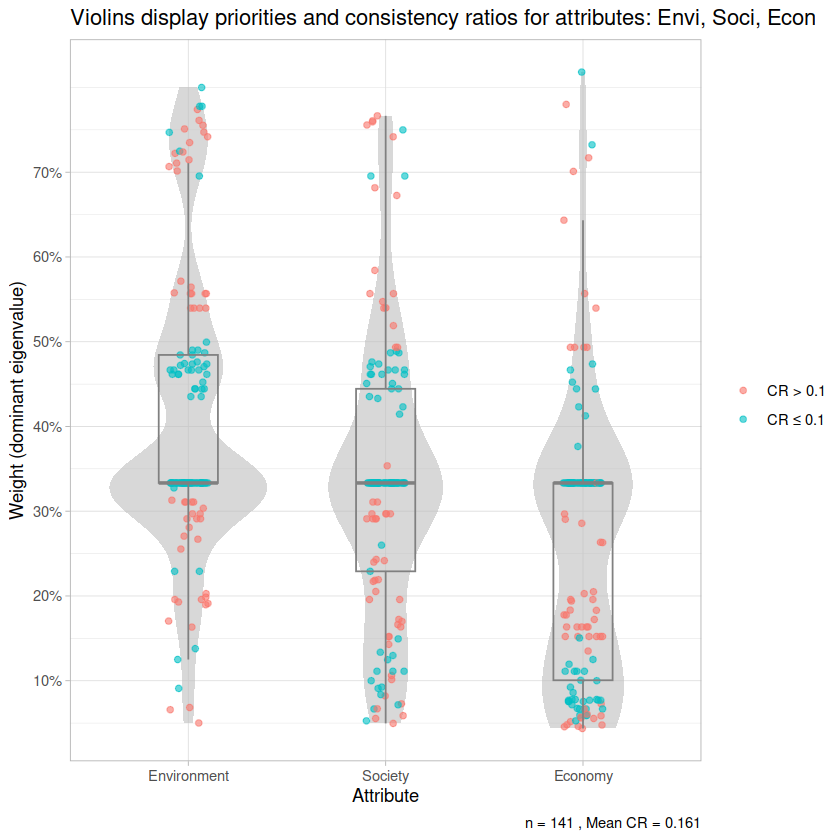

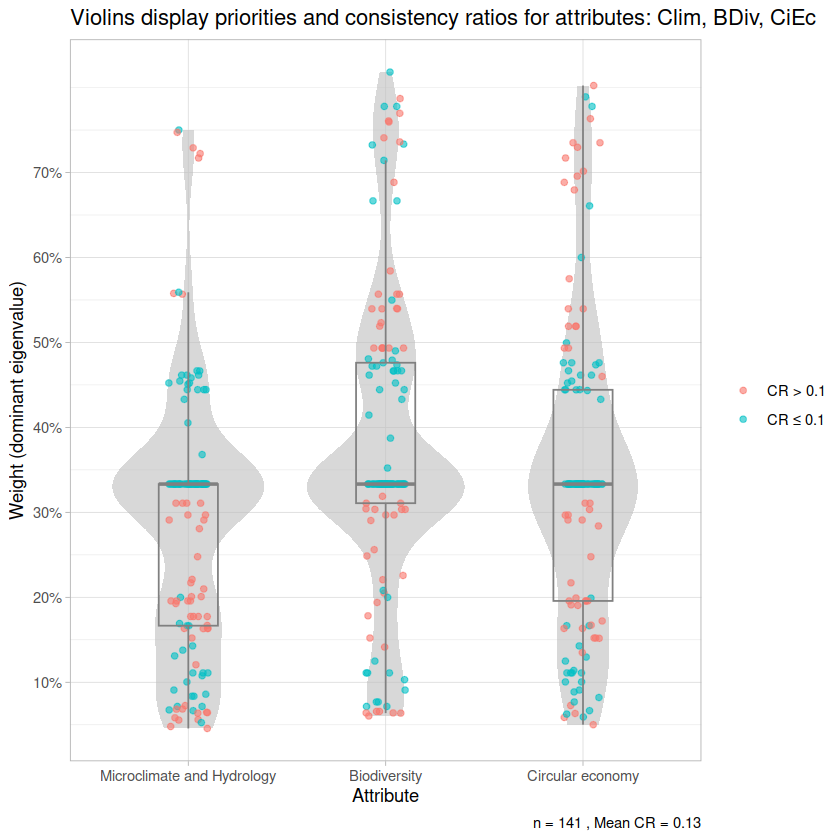

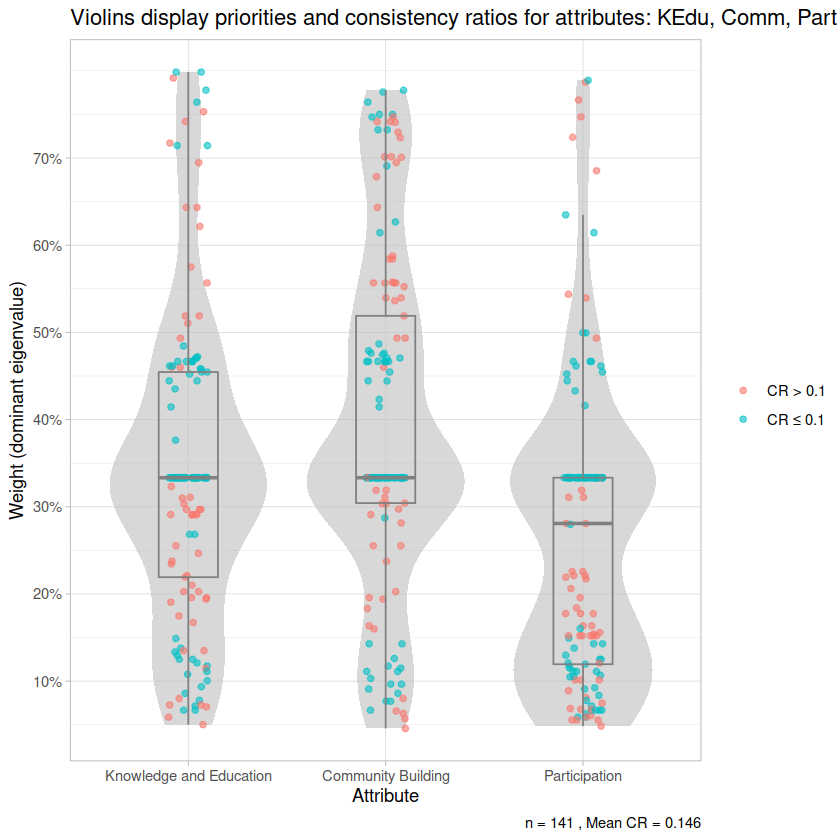

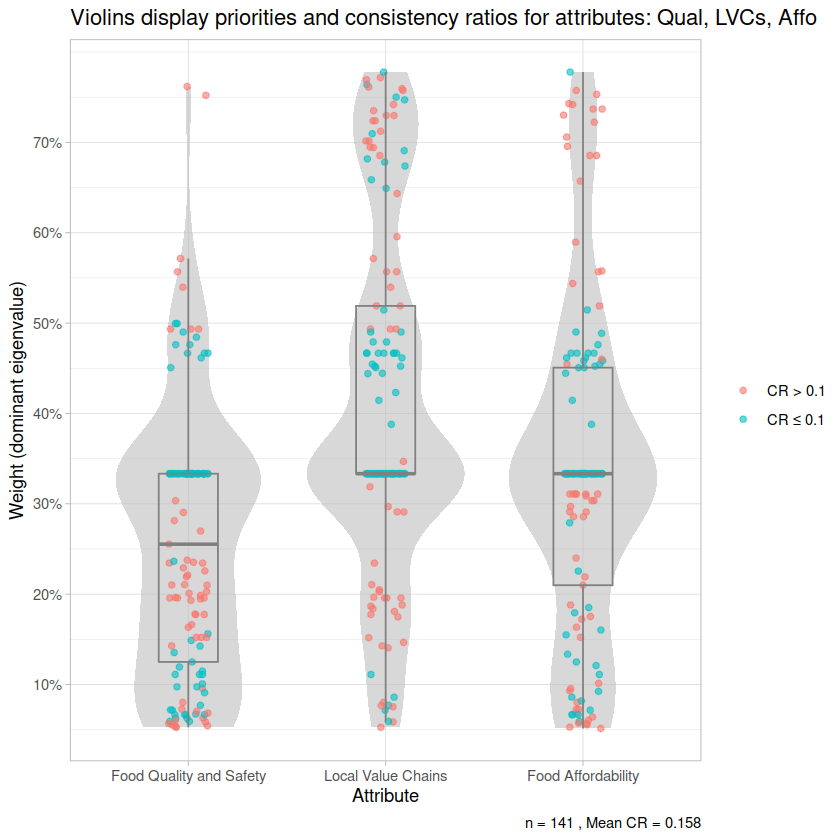

In [35]:
func_process_ahpsurvey(df_csvInputFiles_all, "all", str_input_path_ahp, str_output_path_ahp, df_attributes_labels)

### Participants of city administrations

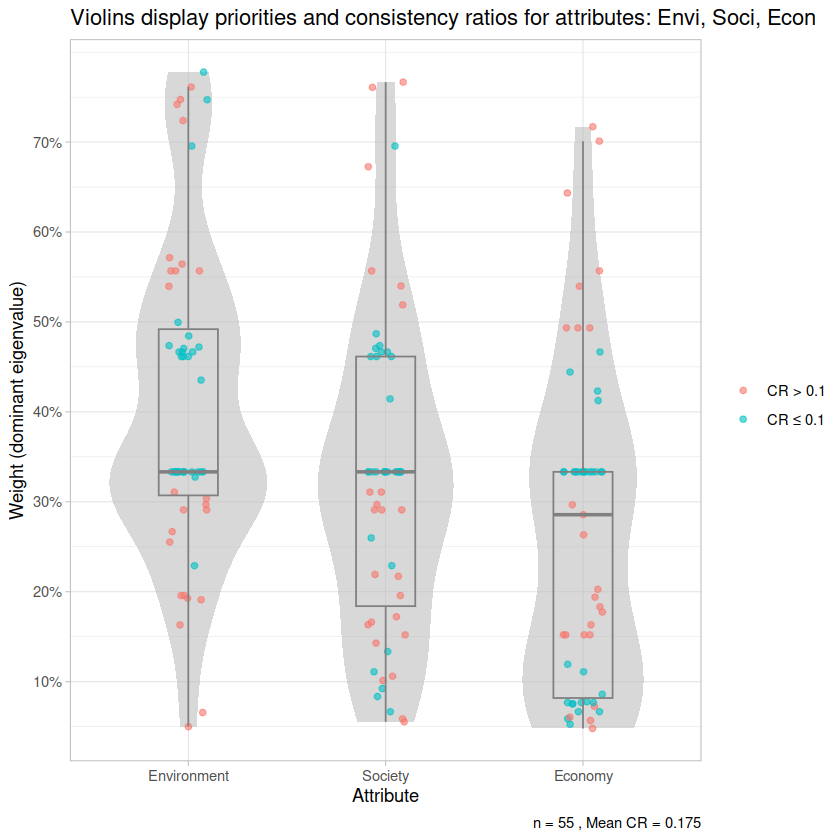

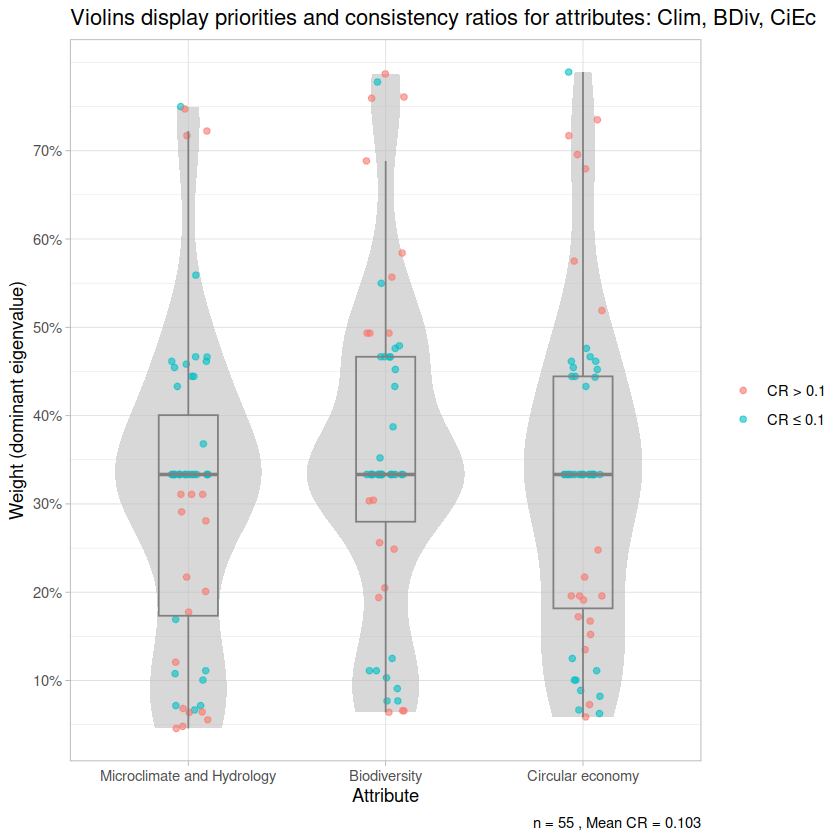

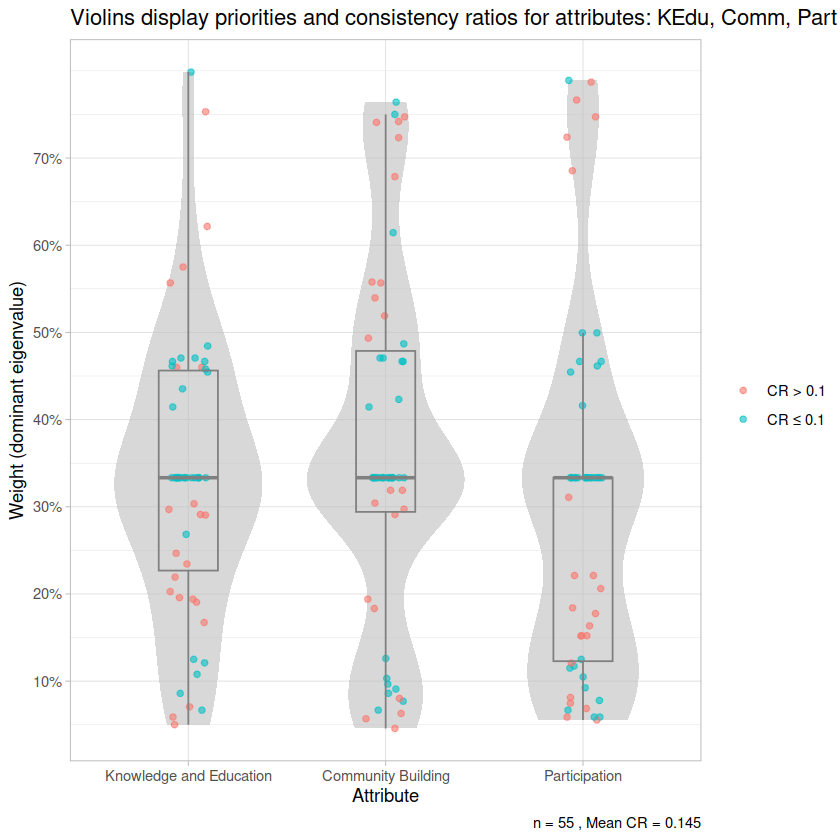

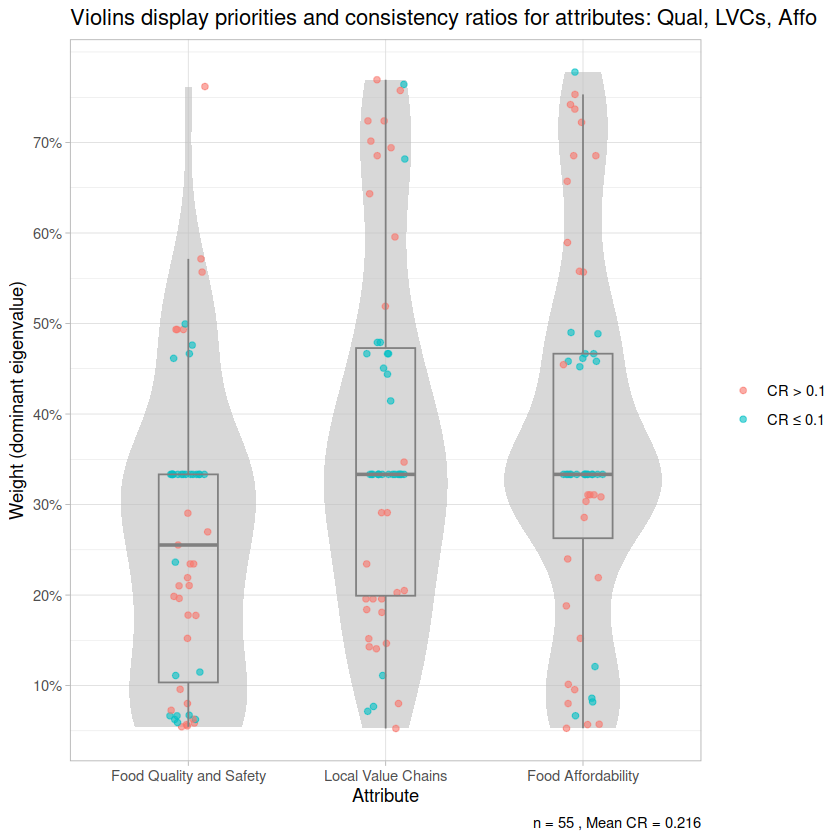

In [36]:
func_process_ahpsurvey(df_csvInputFiles_CA, "CA", str_input_path_ahp, str_output_path_ahp, df_attributes_labels)

### Participants of non-governmental organizations

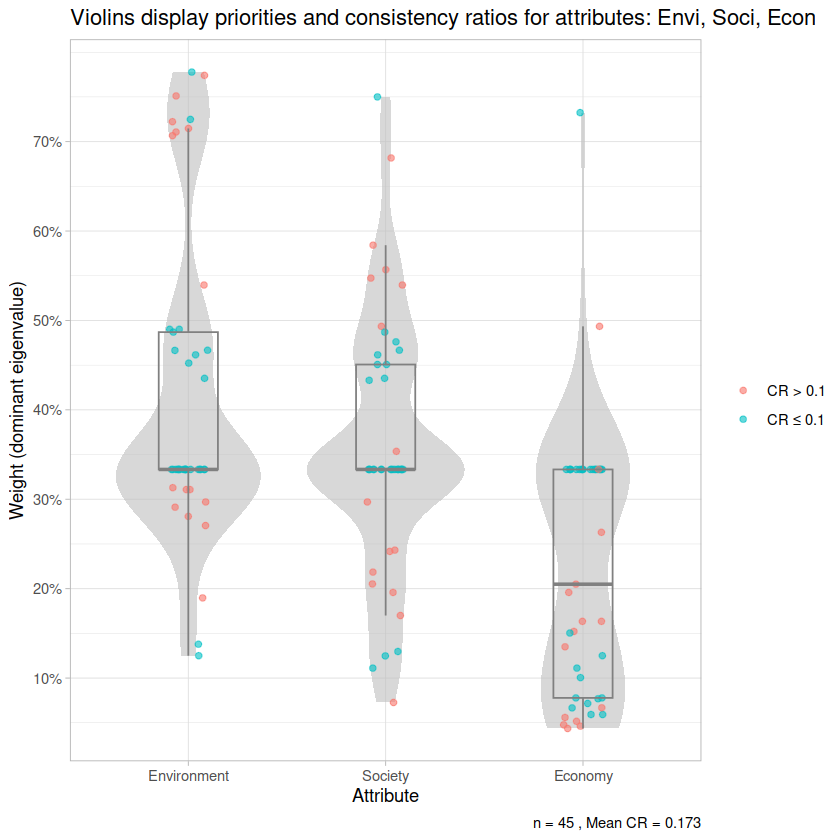

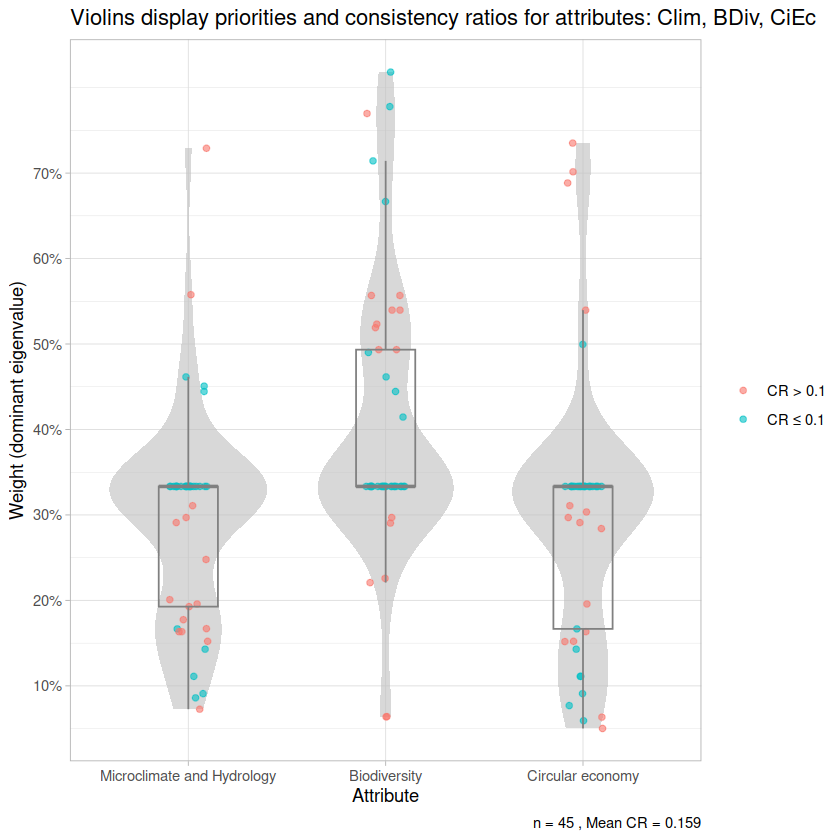

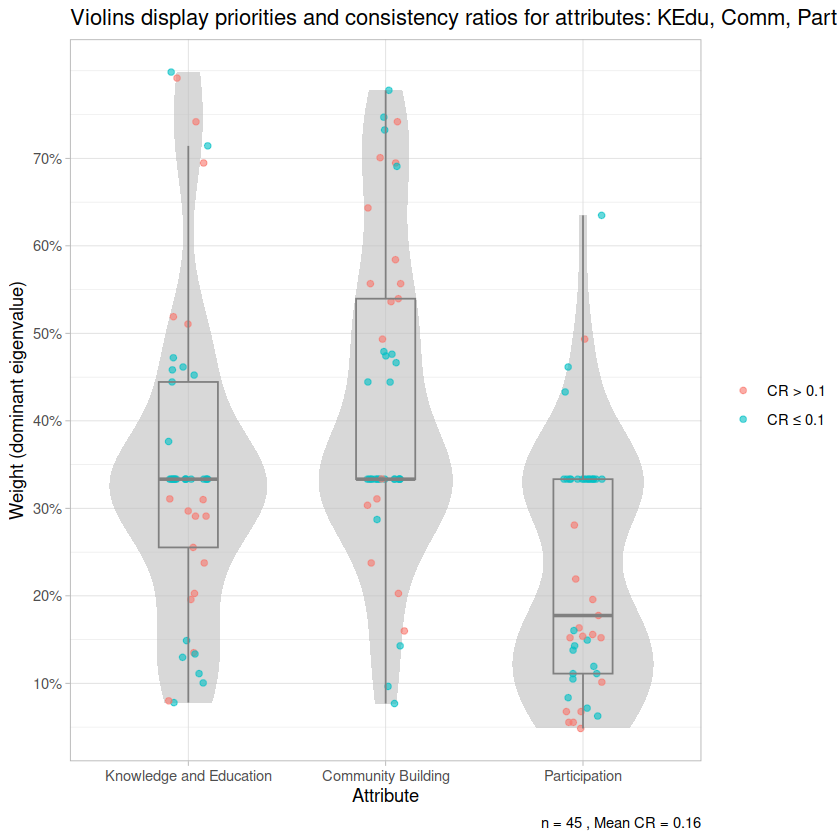

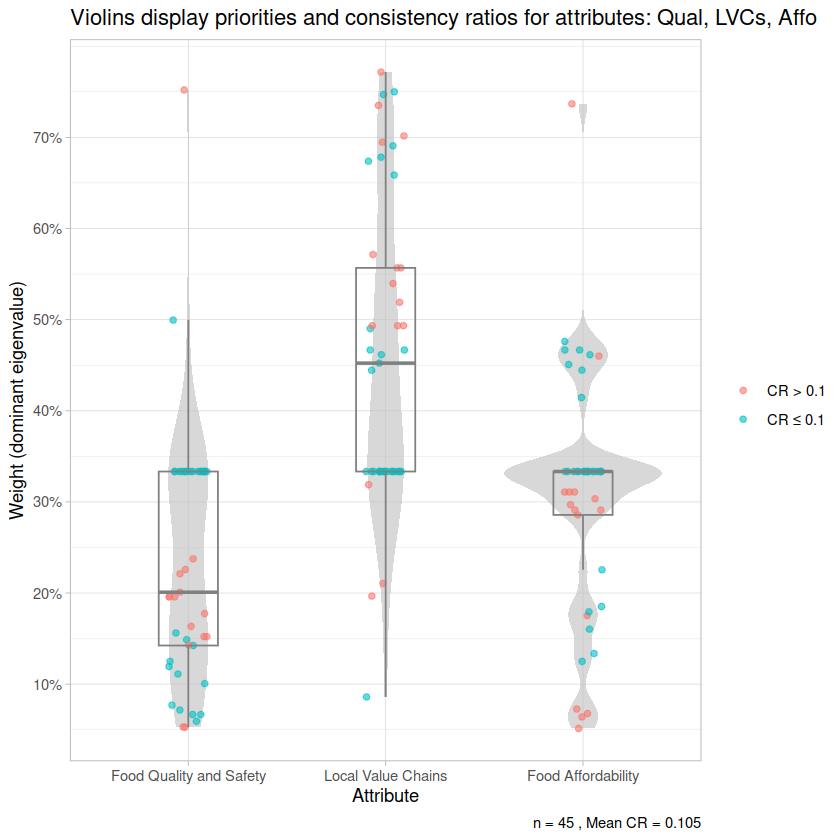

In [37]:
func_process_ahpsurvey(df_csvInputFiles_NGO, "NGO", str_input_path_ahp, str_output_path_ahp, df_attributes_labels)

### Participants of practitioners and experts

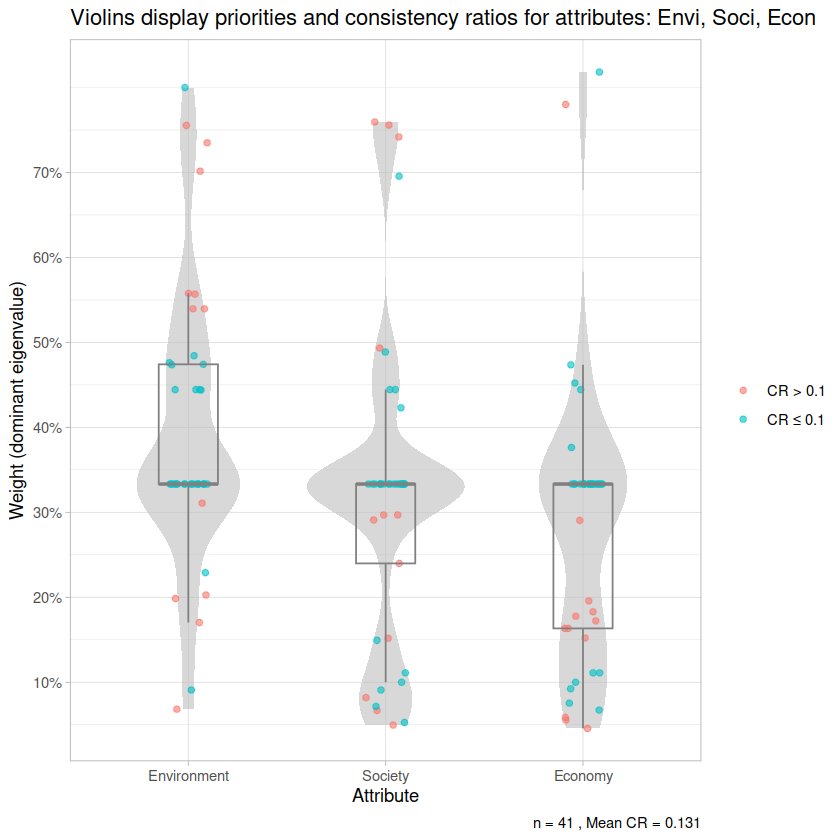

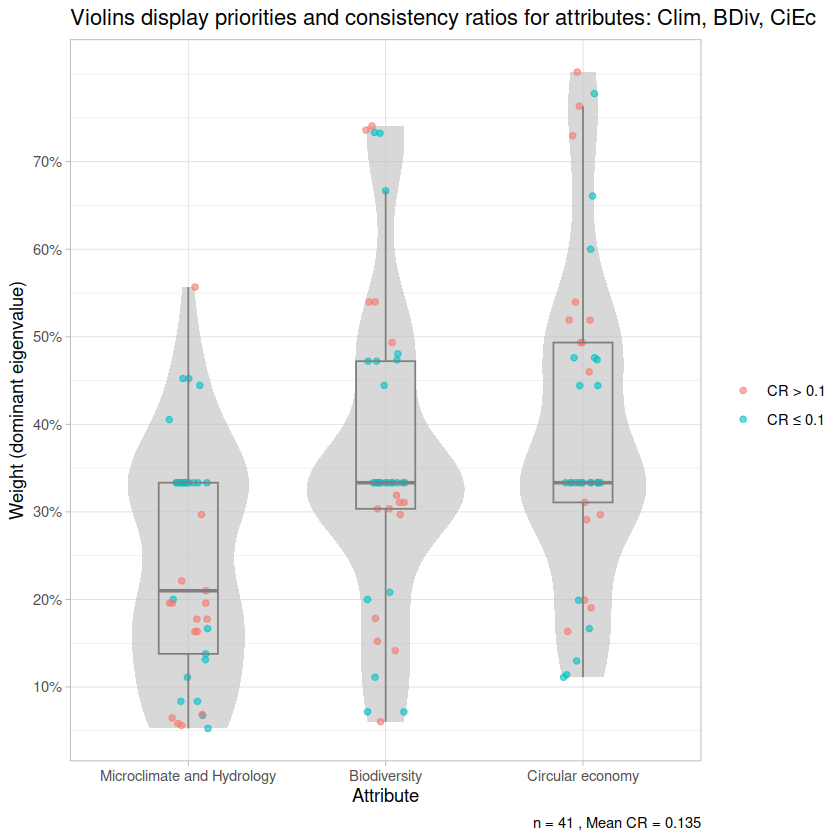

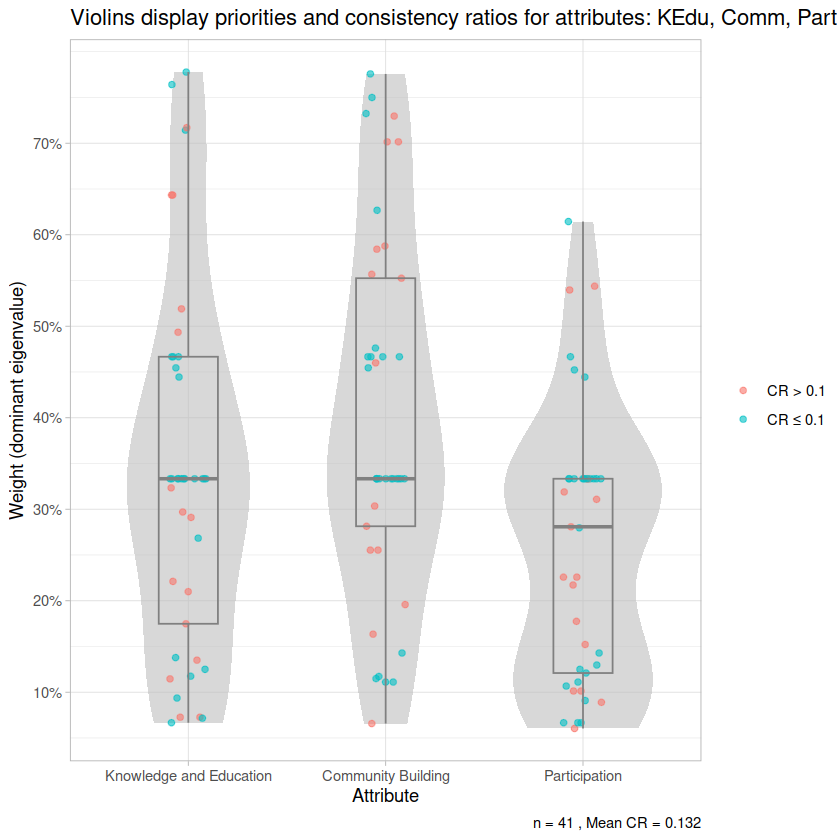

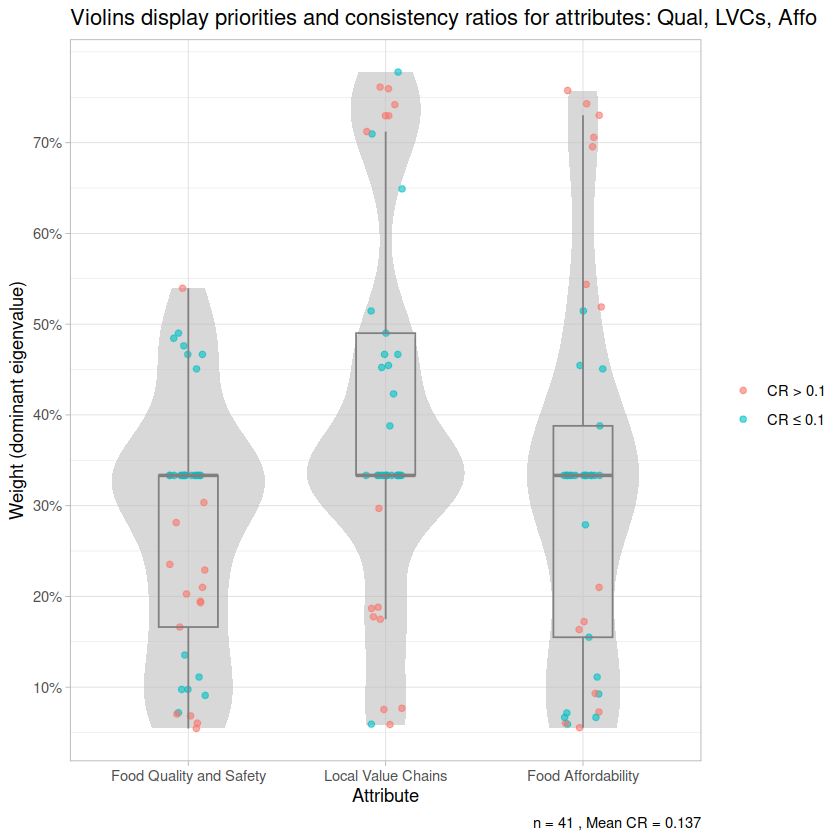

In [38]:
func_process_ahpsurvey(df_csvInputFiles_PE, "PE", str_input_path_ahp, str_output_path_ahp, df_attributes_labels)

## Calculate aggregated preference weights for consistent datasets

In [39]:
func_calc_pref_weights(df_csvInputFiles_all, str_input_path_ahp, df_attributes_labels)

Table: Aggregated weights for  criteria (main criteria)

|     | gmean.raw| gmean.norm|
|:----|---------:|----------:|
|Envi | 0.3739039|  0.4179807|
|Soci | 0.3023657|  0.3380094|
|Econ | 0.2182787|  0.2440099|
|Sum  | 0.8945482|  1.0000000|

Table: Aggregated weights for  environmental sub-criteria

|     | gmean.raw| gmean.norm| gmean.total|
|:----|---------:|----------:|-----------:|
|Clim | 0.2741300|  0.3089871|   0.1291506|
|BDiv | 0.3291718|  0.3710277|   0.1550824|
|CiEc | 0.2838874|  0.3199852|   0.1337476|
|Sum  | 0.8871892|  1.0000000|   0.4179807|

Table: Aggregated weights for  social sub-criteria

|     | gmean.raw| gmean.norm| gmean.total|
|:----|---------:|----------:|-----------:|
|KEdu | 0.3018698|  0.3512801|   0.1187360|
|Comm | 0.3212634|  0.3738480|   0.1263641|
|Part | 0.2362090|  0.2748719|   0.0929093|
|Sum  | 0.8593422|  1.0000000|   0.3380094|

Table: Aggregated weights for  economic sub-criteria

|     | gmean.raw| gmean.norm| gmean.total|
|:----|---------:|----------:|-----------:|
|Qual | 0.2329901|  0.2625724|   0.0640703|
|LVCs | 0.3666029|  0.4131498|   0.1008127|
|Affo | 0.2877435|  0.3242777|   0.0791270|
|Sum  | 0.8873365|  1.0000000|   0.2440099|

# Summary and outlook